In [4]:
!pip install --upgrade -q datasets pyarrow edist


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import re
import random
import numpy as np
import pandas as pd
import edist.sed as sed
from datasets import Dataset, load_dataset, concatenate_datasets

from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [6]:
test = load_dataset(
    "csv",
    split="train",
    usecols=["text1", "text2"],
    data_files=["C:/Users/User/Desktop/FYP3/output.csv"],
)
test = test.rename_column("text1", "src")
test = test.rename_column("text2", "tgt")
test

Dataset({
    features: ['src', 'tgt'],
    num_rows: 373
})

In [7]:
train = load_dataset(
    "csv",
    split="train",
    usecols=["src", "tgt"],
    data_files=["C:/Users/User/Desktop/FYP3/sentences.csv"],
)
train

Dataset({
    features: ['src', 'tgt'],
    num_rows: 17216
})

## Augment train data with random pairs

In [8]:
df = pd.read_csv("C:/Users/User/Desktop/FYP3/sentences.csv")
len(df)

17216

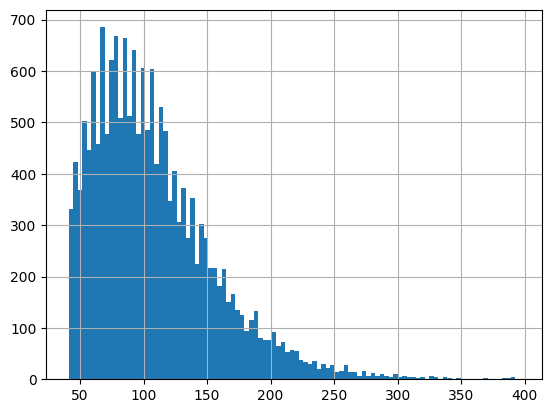

In [6]:
df.tgt.str.len().hist(bins=100);

In [7]:
df = df[df.tgt.str.len() < 150]
len(df)

14246

In [8]:
pairs_df = []
for prompt_id, group in df.groupby("prompt_id"):
    group = group.sample(frac=1, random_state=38)
    odd_rows = group.iloc[1::2, :]
    even_rows = group.iloc[::2, :]
    for a, b in zip(odd_rows.itertuples(), even_rows.itertuples()):
        src = " ".join([a.src, b.src])
        tgt = " ".join([a.tgt, b.tgt])
        pairs_df.append([src, tgt])
pairs_df = pd.DataFrame(pairs_df, columns=["src", "tgt"])
len(pairs_df)

7122

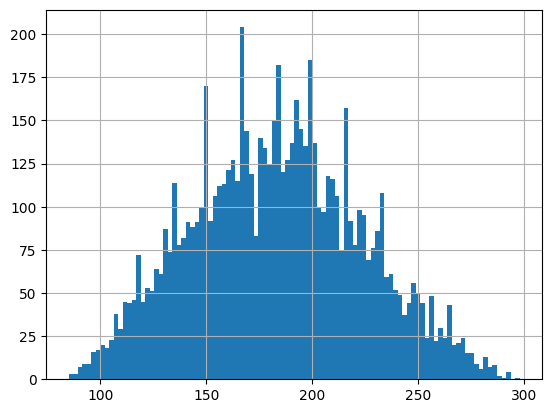

In [9]:
pairs_df.tgt.str.len().hist(bins=100);

In [10]:
train = concatenate_datasets([train, Dataset.from_pandas(pairs_df)])
train

Dataset({
    features: ['src', 'tgt'],
    num_rows: 24338
})

## Tokenize data

In [9]:
model_checkpoint = "jasonlau/en-grammar-correction"

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [11]:
top_20_substitutions = [
    (('a', 't'), 644),
    (('i', 's'), 379),
    (('o', 's'), 173),
    (('', '-'), 172),
    (('i', 't'), 110),
    (('', ')'), 91),
    (('', '('), 90),
    (('e', ''), 79),
    (('i', 'r'), 45),
    (('', ' '), 42),
    (('', ';'), 36),
    (('', "'"), 23),
    (('', 'e'), 22),
    (('i', ''), 22),
    (('', 's'), 21),
    (('e', 'i'), 21),
    (('r', ''), 20),
    (('d', ''), 18),
    (('', '$'), 17),
    (('t', ''), 17),
]

In [12]:
def preprocess(examples, aug_input=None):
    if aug_input is None:
        inputs = examples["src"]
        outputs = examples["tgt"]
    else:
        inputs = []
        outputs = []
        for src, tgt in zip(examples["src"], examples["tgt"]):
            s = random.choice(["t", "s"])
            t = random.choice(["a", "i", "o"])
            if aug_input == "tgt":
                src = tgt
            src = re.sub(s, t, src, flags=re.IGNORECASE)
            src = re.sub(r"[();\-\'\$]", "", src)
            inputs.append(src)
            outputs.append(tgt)
    inputs = tokenizer(inputs)
    labels = tokenizer(text_target=outputs)
    inputs["labels"] = labels["input_ids"]
    return inputs

def preprocess_aug_src(examples):
    return preprocess(examples, "src")

def preprocess_aug_tgt(examples):
    return preprocess(examples, "tgt")

In [13]:
random.seed(38)

In [21]:
tokenized_train = concatenate_datasets([
    train.map(preprocess, batched=True),
    train.map(preprocess_aug_src, batched=True),
    train.map(preprocess_aug_tgt, batched=True),
])
tokenized_train

Dataset({
    features: ['src', 'tgt', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 51648
})

In [22]:
tokenized_test = test.map(preprocess, batched=True)
tokenized_test

Dataset({
    features: ['src', 'tgt', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 373
})

## Build model

In [16]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)


In [17]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [18]:
import torch

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to the GPU
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [19]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Replace -100 as we can't decode them.
    predictions = np.where(predictions != -100, predictions, tokenizer.pad_token_id)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Measure Edit Distance
    distances = []
    for p, g in zip(decoded_preds, decoded_labels):
        d = sed.standard_sed(p, g)
        distances.append(d)
    result = {"ed": np.mean(distances)}
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["len"] = np.mean(prediction_lens)
    return {k: round(v, 4) for k, v in result.items()}

In [23]:
OUTPUT_DIR = "deobfuscator-v1"
POINT_STEPS = 500

args = Seq2SeqTrainingArguments(
    OUTPUT_DIR,
    learning_rate=3e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=POINT_STEPS,
    weight_decay=0.05,
    max_grad_norm=0.5,
    save_total_limit=2,
    num_train_epochs=1,
    predict_with_generate=True,
    generation_max_length=100,
    report_to="none",
    # log_level="info",
    logging_strategy="steps",
    logging_steps=POINT_STEPS,
    evaluation_strategy="steps",
    eval_steps=POINT_STEPS,
    save_strategy="steps",
    save_steps=POINT_STEPS,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [23]:
trainer.train()

 11%|█         | 500/4564 [1:00:02<8:40:28,  7.68s/it]

{'loss': 0.5648, 'grad_norm': 0.9064752459526062, 'learning_rate': 0.00029759999999999997, 'epoch': 0.11}


                                                      
 11%|█         | 500/4564 [1:00:50<8:40:28,  7.68s/it]

{'eval_loss': 1.200323224067688, 'eval_ed': 5.126, 'eval_len': 23.8794, 'eval_runtime': 47.5078, 'eval_samples_per_second': 7.851, 'eval_steps_per_second': 0.505, 'epoch': 0.11}


 22%|██▏       | 1000/4564 [2:02:05<7:08:05,  7.21s/it]

{'loss': 0.246, 'grad_norm': 0.5115258097648621, 'learning_rate': 0.00026360728346456694, 'epoch': 0.22}


                                                       
 22%|██▏       | 1000/4564 [2:02:52<7:08:05,  7.21s/it]

{'eval_loss': 1.191679835319519, 'eval_ed': 4.63, 'eval_len': 23.941, 'eval_runtime': 47.6591, 'eval_samples_per_second': 7.826, 'eval_steps_per_second': 0.504, 'epoch': 0.22}


 33%|███▎      | 1500/4564 [3:03:41<6:21:10,  7.46s/it] 

{'loss': 0.1813, 'grad_norm': 0.6084572672843933, 'learning_rate': 0.00022691929133858267, 'epoch': 0.33}


                                                       
 33%|███▎      | 1500/4564 [3:04:28<6:21:10,  7.46s/it]

{'eval_loss': 1.183348536491394, 'eval_ed': 4.5013, 'eval_len': 23.9383, 'eval_runtime': 47.8056, 'eval_samples_per_second': 7.802, 'eval_steps_per_second': 0.502, 'epoch': 0.33}


 44%|████▍     | 2000/4564 [4:23:39<4:47:58,  6.74s/it]   

{'loss': 0.144, 'grad_norm': 0.5637809634208679, 'learning_rate': 0.0001903051181102362, 'epoch': 0.44}


                                                       
 44%|████▍     | 2000/4564 [4:24:28<4:47:58,  6.74s/it]

{'eval_loss': 1.1495035886764526, 'eval_ed': 4.437, 'eval_len': 23.9517, 'eval_runtime': 48.0971, 'eval_samples_per_second': 7.755, 'eval_steps_per_second': 0.499, 'epoch': 0.44}


 55%|█████▍    | 2500/4564 [5:26:25<4:05:21,  7.13s/it] 

{'loss': 0.1213, 'grad_norm': 0.36715859174728394, 'learning_rate': 0.00015354330708661416, 'epoch': 0.55}


                                                       
 55%|█████▍    | 2500/4564 [5:27:27<4:05:21,  7.13s/it]

{'eval_loss': 1.0967521667480469, 'eval_ed': 4.2788, 'eval_len': 23.9786, 'eval_runtime': 61.8518, 'eval_samples_per_second': 6.031, 'eval_steps_per_second': 0.388, 'epoch': 0.55}


 66%|██████▌   | 3000/4564 [6:29:24<2:41:52,  6.21s/it] 

{'loss': 0.1156, 'grad_norm': 0.31714868545532227, 'learning_rate': 0.00011670767716535431, 'epoch': 0.66}


                                                       
 66%|██████▌   | 3000/4564 [6:30:22<2:41:52,  6.21s/it]

{'eval_loss': 1.0082951784133911, 'eval_ed': 4.1769, 'eval_len': 23.9893, 'eval_runtime': 57.9221, 'eval_samples_per_second': 6.44, 'eval_steps_per_second': 0.414, 'epoch': 0.66}


 77%|███████▋  | 3500/4564 [7:31:17<1:59:42,  6.75s/it] 

{'loss': 0.1166, 'grad_norm': 0.9219802021980286, 'learning_rate': 7.987204724409448e-05, 'epoch': 0.77}


                                                       
 77%|███████▋  | 3500/4564 [7:32:16<1:59:42,  6.75s/it]

{'eval_loss': 0.9858730435371399, 'eval_ed': 4.2815, 'eval_len': 23.9705, 'eval_runtime': 58.3631, 'eval_samples_per_second': 6.391, 'eval_steps_per_second': 0.411, 'epoch': 0.77}


 88%|████████▊ | 4000/4564 [8:33:42<1:10:59,  7.55s/it]

{'loss': 0.1188, 'grad_norm': 0.09570327401161194, 'learning_rate': 4.318405511811023e-05, 'epoch': 0.88}


                                                       
 88%|████████▊ | 4000/4564 [8:34:41<1:10:59,  7.55s/it]

{'eval_loss': 1.0024709701538086, 'eval_ed': 4.3137, 'eval_len': 24.0, 'eval_runtime': 59.1126, 'eval_samples_per_second': 6.31, 'eval_steps_per_second': 0.406, 'epoch': 0.88}


 99%|█████████▊| 4500/4564 [9:36:17<07:06,  6.66s/it]  

{'loss': 0.1152, 'grad_norm': 0.065519317984581, 'learning_rate': 6.4222440944881885e-06, 'epoch': 0.99}


                                                     
 99%|█████████▊| 4500/4564 [9:37:17<07:06,  6.66s/it]

{'eval_loss': 1.01128089427948, 'eval_ed': 4.3432, 'eval_len': 23.9973, 'eval_runtime': 59.8027, 'eval_samples_per_second': 6.237, 'eval_steps_per_second': 0.401, 'epoch': 0.99}


100%|██████████| 4564/4564 [9:44:58<00:00,  7.69s/it]

{'train_runtime': 35098.7212, 'train_samples_per_second': 2.08, 'train_steps_per_second': 0.13, 'train_loss': 0.190394144325691, 'epoch': 1.0}


TrainOutput(global_step=4564, training_loss=0.190394144325691, metrics={'train_runtime': 35098.7212, 'train_samples_per_second': 2.08, 'train_steps_per_second': 0.13, 'total_flos': 8087605425653760.0, 'train_loss': 0.190394144325691, 'epoch': 1.0})

In [24]:
model = model.eval()
text = [
   "There is no poina. Bua ahaa's whaa we're doing when we voae.",
   "Uiing cari today ii polauting the air we breath in everyday, worie and wroie.",
]
input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)
outputs = model.generate(input_ids, max_length=100)
tokenizer.batch_decode(outputs, skip_special_tokens=True)

["There is no poina. Bua ahaa's what we're doing when we voae.",
 'Uiing cari today ii painting the air we breathe every day, worie and woie.']

In [35]:
trainer.evaluate(tokenized_test)

100%|██████████| 24/24 [00:55<00:00,  2.31s/it]


{'eval_loss': 1.0114930868148804,
 'eval_ed': 4.3458,
 'eval_len': 23.9973,
 'eval_runtime': 57.9958,
 'eval_samples_per_second': 6.432,
 'eval_steps_per_second': 0.414,
 'epoch': 1.0}

In [38]:
tokenizer.save_pretrained(OUTPUT_DIR)

('deobfuscator-v1\\tokenizer_config.json',
 'deobfuscator-v1\\special_tokens_map.json',
 'deobfuscator-v1\\spiece.model',
 'deobfuscator-v1\\added_tokens.json',
 'deobfuscator-v1\\tokenizer.json')

In [39]:
model.config.save_pretrained(OUTPUT_DIR)

In [41]:
trainer.save_state()
trainer.save_model(OUTPUT_DIR)

In [25]:
import torch

In [26]:
class GEC(object):
    def __init__(self, model, tokenizer):
        torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.device = torch_device
        self.model = model.to(torch_device)
        self.tokenizer = tokenizer
        
    def correct(self, input):
        prefix = "grammar: "
        input = prefix + input
        input_ids = self.tokenizer(input, return_tensors="pt").input_ids.to(self.device)
        outputs = self.model.generate(input_ids, max_length=128, num_beams=5, early_stopping=True)
        cor = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return cor

In [29]:
model_path = "deobfuscator-v1"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

gec = GEC(model, tokenizer)

orig = """He tocks nonsense."""
cor = gec.correct(orig)
print(cor)

He tells nonsense.
